# Introduction

This notebook explores a modern controller for *a simple point mass* in the plane.

A modern controller has two components: the trajectory generator and the trajectory tracking controller.

From the given command to the robot system, e.g., move to a reference joint position, the trajectory
generator computes a desired trajectory. This trajectory is 2-tuple consisting of the desired state trajectory
and the feedforward control trajectory.

The trajectory tracking controller computes a feedback control
from the difference between the desired state and measured state, then adds that to the feedforward control
signal and executs the resulting control on the robotic system.

# Trajectory Tracking
Let $q \in R^2$ denote the position of the point mass.
The equation
of motion is given simply by
$$\ddot q = u,$$ where 
I have assumed the weight to be 1. Using the vector $x = [\dot q, \ddot q]$ as the state
of the system, the state-space form of the e.o.m. is given by
$$\dot x = Ax + Bu,$$
where 
$$
A = \begin{bmatrix}
 0 & I \\ 0 & 0
\end{bmatrix}, B = \begin{bmatrix} 0 \\ I \end{bmatrix}.
$$

A desired trajectory is a tuple of a state trajectory $x_d$, 
and feedforward control trajectory $u_{ff}(t)$ that satisfies the e.o.m. (Murray, 2012)

The state-feedback trajectory tracking controller is then given by
$$u = u_{ff} - K (x - x_d).$$
where $K$ is a state-feedback matrix s.t. $A - BK$ is Hurwitz. A possible choice of $K$ is given below. I will
use this value in the simulations
$$\begin{bmatrix}
\lambda ^ 2 & & 2\lambda & \\
& \lambda ^ 2 & & 2 \lambda
\end{bmatrix}$$

It can be noted that the control is composed of three terms. The first and third terms are from
the desired trajectory and feedforward control. The second term is from full-state feedback.

In [3]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt

A = np.array([[0, 0, 1, 0],
              [0, 0, 0, 1],
             [0, 0, 0, 0],
             [0, 0, 0, 0]], dtype=float)
B = np.array([[0, 0], [0, 0], [1, 0], [0, 1]], dtype=float)

flambda = 2.0
K = np.array([[flambda ** 2, 0, 2 * flambda, 0], [0, flambda **2, 0, 2 * flambda]])

## Compute desired trajectory

Consider the feedforward control $$u_{ff} = (\sin (t), \cos(t)), t \in [0, \pi]$$
The desired state-trajectory $x_d$ can be computed by substituing $u_{ff}$ in the state
equation and perform numerical integration.

This is done in the next cell.

In [4]:
def g(t, x):
    u = np.array([np.sin(t), np.cos(t)])
    return A.dot(x) + B.dot(u)

r = ode(g)
r.set_integrator('dopri5')
r.set_initial_value(np.r_[-3, 0, 0, 0])
dt = 1e-2
T = 2 * np.pi

xd = []
uff = []
while r.successful() and r.t < T:
    xd.append(r.y)
    uff.append(np.array([np.sin(r.t), np.cos(r.t)]))
    r.integrate(r.t + dt)
xd = np.array(xd)
uff = np.array(uff)

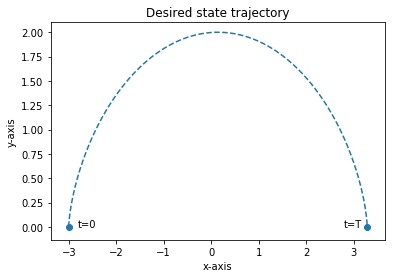

In [5]:
plt.plot(xd[:, 0], xd[:, 1], '--')
plt.scatter(xd[[0, -1], 0], xd[[0, -1], 1])
plt.annotate('t=0', xd[0, :2], [-2.8, 0])
plt.annotate('t=T', xd[-1, :2], [2.8, 0])
plt.title('Desired state trajectory')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.show()

## Simulate trajectory tracking

We can now simulate the point mass under the trajectory tracking controller that I have described
in the previous cell.

This simulation is done using 'dopri5' ODE solver.

In [6]:
def g(t, x, u):
    return A.dot(x) + B.dot(u)

r = ode(g)
r.set_integrator('dopri5')
r.set_initial_value(np.r_[-2, -1, 5, 0])
dt = 1e-2
T = 2 * np.pi

i = 0
x = []
u = []
while r.successful() and r.t < T:
    x.append(r.y)
    u.append(uff[i] - K.dot(r.y - xd[i]))
    r.set_f_params(uff[i] - K.dot(r.y - xd[i]))
    r.integrate(r.t + dt)
    i += 1
x = np.array(x)
u = np.array(u)

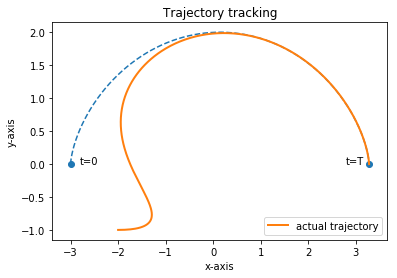

In [7]:
plt.plot(xd[:, 0], xd[:, 1], '--')
plt.scatter(xd[[0, -1], 0], xd[[0, -1], 1])
plt.plot(x[:, 0], x[:, 1], lw=2, label='actual trajectory')
plt.annotate('t=0', xd[0, :2], [-2.8, 0])
plt.annotate('t=T', xd[-1, :2], [2.8, 0])
plt.title('Trajectory tracking')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend()
plt.show()

## Trajectory Tracking with bounded-control

Notice that the feedforward control trajectory $u_d(t)$ satisfies the control bound $[-1, 1]$. The actual control
trajectory $u(t)$, however, is not guaranteed to be so. Indeed, the control trajectory of the simulation I have done in the previous cell is plotted below.

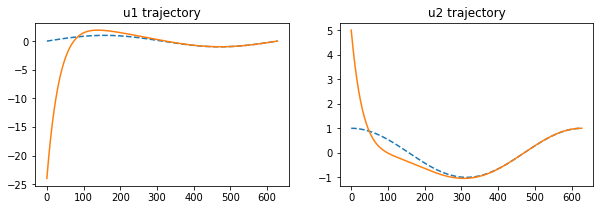

In [8]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10, 3))
axs[0].plot(uff[:, 0], '--')
axs[0].plot(u[:, 0])
axs[0].set_title('u1 trajectory')
axs[1].plot(uff[:, 1], '--')
axs[1].plot(u[:, 1])
axs[1].set_title('u2 trajectory')
plt.show()

What happen if we enforce the bounds on control in the second simulation?

The below cells simulate this case and plot the resulting trajectory.

In [9]:
def g(t, x, u):
    return A.dot(x) + B.dot(u)

r = ode(g)
r.set_integrator('dopri5')
r.set_initial_value(np.r_[-2, -1, 0, 0])
dt = 1e-2
T = 2 * np.pi

umin = [-1, -1]
umax = [1, 1]

i = 0
x = []
u = []
while r.successful() and r.t < T:
    x.append(r.y)
    u_ = np.clip(uff[i] - K.dot(r.y - xd[i]), umin, umax)
    u.append(u_)
    r.set_f_params(u_)
    r.integrate(r.t + dt)
    i += 1
x = np.array(x)
u = np.array(u)

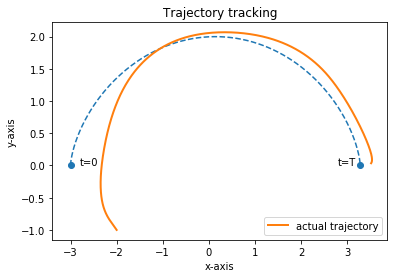

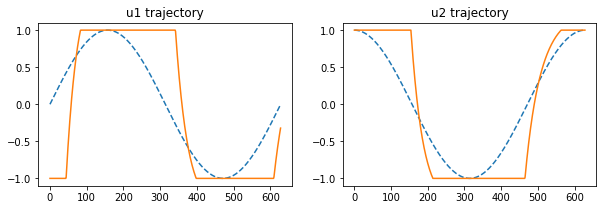

In [10]:
plt.plot(xd[:, 0], xd[:, 1], '--')
plt.scatter(xd[[0, -1], 0], xd[[0, -1], 1])
plt.plot(x[:, 0], x[:, 1], lw=2, label='actual trajectory')
plt.annotate('t=0', xd[0, :2], [-2.8, 0])
plt.annotate('t=T', xd[-1, :2], [2.8, 0])
plt.title('Trajectory tracking')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend()

fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10, 3))
axs[0].plot(uff[:, 0], '--')
axs[0].plot(u[:, 0])
axs[0].set_title('u1 trajectory')
axs[1].plot(uff[:, 1], '--')
axs[1].plot(u[:, 1])
axs[1].set_title('u2 trajectory')

plt.show()

Clearly with control bound it is much harder to track the trajectory.

# Path Tracking

This section considers the problem of tracking a geometric path $p(s): [0, t] \mapsto R^n$.
I consider a controller with the general architecture described in (Murray, Feedback system chapter 7), which
combines a trajectory generator and a state feedback. With the objective of path tracking we can
use a more specific controller architecture as below:

![title](img/Gen_controller.png)

At each control cycle at run time, the following steps are performed:
1. $x$ is measured;
2. the trajectory generator selects a *SUITABLE* path acceleration $\ddot s$, from which
   it computes the desired joint acceleration using $$\ddot q_d = p'(s)\ddot s + p''(s)\dot s^2$$
3. compute the feedforward control $u_{ff}(t)$ $$u_{ff} = M(q) \ddot q_d + C(q, \dot q)$$
   and the desired state $x_{d}(t)$ 
   $$x_d = \begin{bmatrix}p(s) \\ p'(s)\dot s\end{bmatrix}$$
4. compute feedback control $u_{fb} = M(q) K (x_d - x)$;
5. execute control $u = u_{ff} + u_{fb}$.

Different path-tracking scheme differs in the method of selecting the path acceleration $\ddot s$.

## Simple Trajectory Tracking

Time-Optimal Path-Parametrization (TOPP) is a classic problem in robotics.
Given a path, one solves TOPP to obtain the fastest trajectory corresponding
to that path subject to constraints on dynamics.

In the framework of Path-Tracking controller given in the begining of this section,
the trajectory generator selects the time-optimal path acceleration at every step.


The resulting trajectory, however, is difficult to track, as it is often the
case that some constraints are saturated, leaving no room for the feedback term.

The next cell demonstrates this procedure and shows that time-optimally parametrized
paths are indeed hard to track.

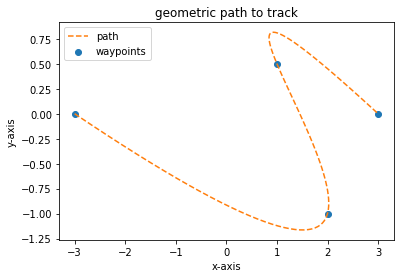

In [59]:
import toppra as ta

waypoints = np.array([[-3, 0], [2, -1], [1, 0.5], [3, 0]], dtype=float)
path = ta.SplineInterpolator([0, 0.33, 0.66, 1.0], waypoints)

plt.scatter(waypoints[:, 0], waypoints[:, 1], label='waypoints')
waypoints_sam = path.eval(np.linspace(0, 1, 100))
plt.plot(waypoints_sam[:, 0], waypoints_sam[:, 1], '--', color='C1', label='path')
plt.legend()
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('geometric path to track')
plt.show()

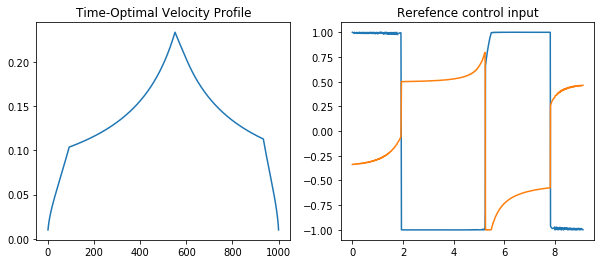

In [66]:
N = 1000
alim = np.array([[-1, 1], [-1, 1]], dtype=float)
constraint = ta.create_acceleration_path_constraint(path, np.linspace(0, 1, N+1), alim)
constraint = ta.interpolate_constraint(constraint)
pp = ta.qpOASESPPSolver([constraint])
us, xs = pp.solve_topp()
t, q, qd, qdd = ta.postprocess.compute_trajectory_uniform(path, np.linspace(0, 1, N+1), us, xs, dt=0.01)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(np.sqrt(xs))
axs[0].set_title('Time-Optimal Velocity Profile')
axs[1].plot(t, qdd)
axs[1].set_title('Rerefence control input')
plt.show()

In [90]:
def g(t, x, u):
    return A.dot(x) + B.dot(u)

r = ode(g)
r.set_integrator('dopri5')
r.set_initial_value(np.r_[-4, -1, 0, 0])
dt = 1e-2
T = t[-1]

uff = np.array(qdd)
xd = np.hstack((q, qd))

relax = 1

umin = np.r_[-1, -1] * relax
umax = np.r_[1, 1] * relax

i = 0
x = []
u = []
while r.successful() and r.t < T:
    x.append(r.y)
    u_ = np.clip(uff[i] - K.dot(r.y - xd[i]), umin, umax)
    u.append(u_)
    r.set_f_params(u_)
    r.integrate(r.t + dt)
    i += 1
x = np.array(x)
u = np.array(u)

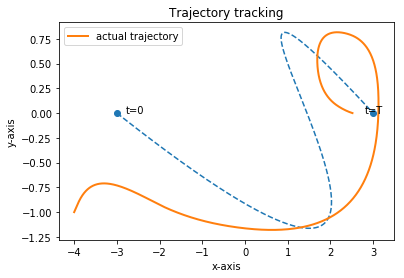

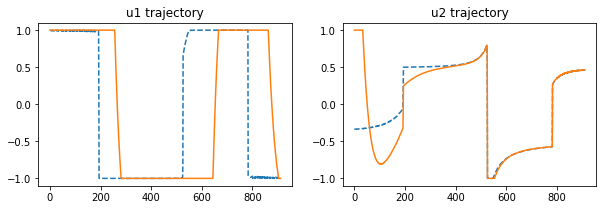

In [91]:
plt.plot(xd[:, 0], xd[:, 1], '--')
plt.scatter(xd[[0, -1], 0], xd[[0, -1], 1])
plt.plot(x[:, 0], x[:, 1], lw=2, label='actual trajectory')
plt.annotate('t=0', xd[0, :2], [-2.8, 0])
plt.annotate('t=T', xd[-1, :2], [2.8, 0])
plt.title('Trajectory tracking')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend()

fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10, 3))
axs[0].plot(uff[:, 0], '--')
axs[0].plot(u[:, 0])
axs[0].set_title('u1 trajectory')
axs[1].plot(uff[:, 1], '--')
axs[1].plot(u[:, 1])
axs[1].set_title('u2 trajectory')

plt.show()

## Online Scaling (Dahl, 1991)



## Online Scaling with Guarantee

In [ ]:
ss